In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
pd.options.display.float_format = '{:.1f}'.format
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [207]:
# Пример данных
df = pd.read_csv('infl_rus.csv')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df

,paid_services,salary,debt_firms,debt_fiz,trade_turnover,money_income,inflation,fm_changes_volume,fm_changes_costs,fm_changes_demand,...,fm_demand_exp,fm_price_exp,Date,Brent,MIACR,Infl_exp,M2,gov_debt,obligates,unemployment
0,559456677.9,29535.0,18171671,9708233,179896.0,25631.0,100.4,-33.6,16.5,-19.0,...,17.9,14.0,2014-01-31,108.1,6.1,13.0,31155.6,5722.2,6.2,6.8
1,571950883.8,29255.3,18184819,9821423,179896.0,25631.0,100.5,0.2,19.8,-5.4,...,20.6,16.5,2014-02-28,108.9,6.0,11.8,29861.2,5733.6,6.4,6.8
2,591568267.2,31485.9,18458002,9964305,179896.0,25631.0,100.8,10.3,22.0,0.6,...,20.3,14.3,2014-03-31,107.5,7.8,11.5,30169.0,5755.0,7.4,6.8
3,599205733.8,32947.3,18790056,10149219,179896.0,25631.0,100.9,3.8,19.2,0.6,...,19.8,12.4,2014-04-30,107.8,7.9,12.7,29519.3,5707.2,7.5,6.8
4,585407816.1,32271.8,19052987,10268231,179896.0,25631.0,100.8,-0.0,17.3,-1.8,...,17.9,11.2,2014-05-31,109.5,8.2,11.7,29879.0,5715.0,8.0,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1385197669.3,76604.2,50471456,29466085,329159.0,47386.0,100.5,6.3,32.9,5.1,...,17.5,20.2,2023-06-30,74.8,7.3,11.1,86197.3,20539.0,12.4,4.2
114,1396609351.2,71419.4,51942940,30001157,329159.0,47386.0,100.5,5.5,38.1,4.6,...,17.5,24.4,2023-07-31,80.1,7.8,11.5,87276.8,20294.5,12.1,4.2
115,1415037312.1,69439.2,53066477,30985631,329159.0,47386.0,100.8,7.2,43.4,6.0,...,12.3,26.4,2023-08-31,86.2,10.3,11.7,88294.0,20376.9,12.8,4.2
116,1461553962.2,70921.5,54559539,31912104,329159.0,47386.0,100.9,1.3,47.3,1.6,...,8.5,26.4,2023-09-30,93.7,12.3,11.2,90110.9,20384.1,13.4,4.2


In [210]:
X[X.apply(lambda x: adfuller(x)[1] < 0.05)]
# X

/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_9450/221487665.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X[X.apply(lambda x: adfuller(x)[1] < 0.05)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [209]:
y = df["inflation"]  
X = df.drop(columns=["inflation", 'Date'])  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_pca[:3]

array([[-3.53843366, -0.29549907,  0.60565812,  3.20414843,  2.18910292,
        -1.53436835],
       [-3.01223975, -1.6234767 , -1.31574927,  0.62021268,  2.43324031,
        -0.63012344],
       [-2.80131926, -1.68297447, -2.26182214, -0.32377216,  1.95465995,
        -0.50963496]])

<Axes: xlabel='components_used', ylabel='mean_squared_errors'>

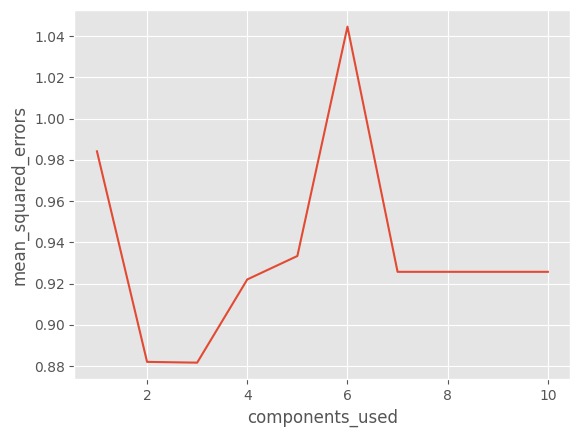

In [115]:
lin_reg = LinearRegression()

components_used = []
mean_squared_errors = []

for i in range(1, 11):
    cv_scores = cross_val_score(estimator=lin_reg,
                                X=X_pca[:, 0:i],
                                y=y,
                                cv=10,
                                scoring="neg_mean_squared_error")

    cv_mean_squared_error = cv_scores.mean() * -1

    components_used.append(i)
    mean_squared_errors.append(cv_mean_squared_error)

mse_by_n_components = \
    pd.DataFrame(data=dict(components_used=components_used,
                           mean_squared_errors=mean_squared_errors))
    
sb.lineplot(data=mse_by_n_components, x='components_used', y='mean_squared_errors')

                            AutoReg Model Results                             
Dep. Variable:              inflation   No. Observations:                  118
Model:                   AutoReg-X(2)   Log Likelihood                -123.370
Method:               Conditional MLE   S.D. of innovations              0.701
Date:                Mon, 07 Apr 2025   AIC                            268.740
Time:                        19:38:54   BIC                            299.029
Sample:                             2   HQIC                           281.036
                                  118                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           96.0499      9.975      9.630      0.000      76.500     115.600
inflation.L1     0.1223      0.083      1.476      0.140      -0.040       0.285
inflation.L2    -0.0771      0.078     -0.98

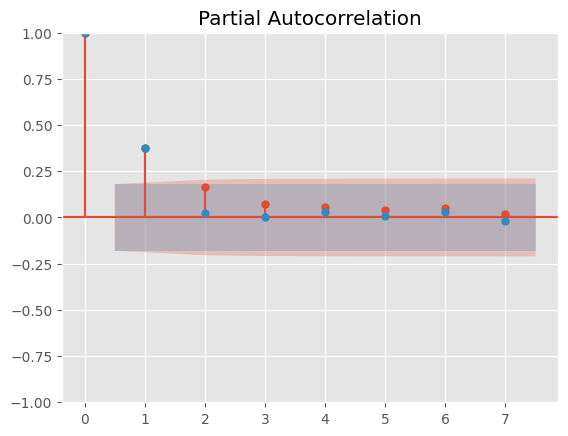

In [123]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=7, ax=plt.gca())  # lags=20 - количество лагов для отображения
plot_pacf(y, lags=7, ax=plt.gca(), method='ols')  # method='ols' для PACF

# Построение ARDL модели
model = AutoReg(y, lags=2, exog=X_pca)
results = model.fit()
result= results.summary()
print(result)

In [75]:
from statsmodels.tsa.ar_model import AutoReg

# Добавляем константу (intercept)
X_sm = sm.add_constant(X_pca)

# OLS-регрессия
model_ols = sm.OLS(y, X_sm)
results_ols = model_ols.fit()

print(results_ols.summary())

# Остатки модели
residuals = results_ols.resid

# Оцениваем AR(p) для остатков
ar_order = 1  # порядок авторегрессии (можно подобрать через AIC)
model_ar = AutoReg(residuals, lags=ar_order)
results_ar = model_ar.fit()

# Прогнозируем AR-ошибки
ar_predictions = results_ar.predict()

# Корректируем исходные данные
y_corrected = y - ar_predictions

# Переоцениваем OLS на скорректированных данных
model_ols_corrected = sm.OLS(y_corrected[1:], X_sm[1:])
results_ols_corrected = model_ols_corrected.fit()
print(results_ols_corrected.summary())

                            OLS Regression Results                            
Dep. Variable:               infl_rus   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     13.58
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.35e-10
Time:                        12:08:43   Log-Likelihood:                -141.32
No. Observations:                 132   AIC:                             294.6
Df Residuals:                     126   BIC:                             311.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6057      0.063      9.632      0.0

In [76]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(X) модель: порядок (1,0,0) = AR(1)
model_arima = ARIMA(y, exog=X_pca, order=(1, 0, 0))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               infl_rus   No. Observations:                  132
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -121.869
Date:                Mon, 07 Apr 2025   AIC                            259.738
Time:                        12:09:29   BIC                            282.801
Sample:                             0   HQIC                           269.110
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3457      1.273      0.272      0.786      -2.149       2.840
x1            -0.5082      0.402     -1.264      0.206      -1.296       0.280
x2             1.0497      0.180      5.831      0.0